# 승촌보 데이터 분석 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 필요한 모듈 임포트

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## matplotlib 한글 설정  
* 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원. 

In [4]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 수질 데이터 불러오기

데이터 저장소

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

승촌보 데이터 불러오기. `'측정일/월'` 특성은 date time으로 파싱.

## 

In [6]:
scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

`scb_yearly`는 연도별 데이터프레임을 갖는 사전 자료형.

In [7]:
print(type(scb_yearly))
print('='*50)
print(scb_yearly.keys())
print('='*50)
print(scb_yearly['2013년'].index)
print('='*50)
print(scb_yearly['2013년'].head(3))

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])
RangeIndex(start=0, stop=8750, step=1)
                측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0 2013-01-01 00:00:00   용봉   3.9     6.9        374.0       11.4         2.5   
1 2013-01-01 01:00:00   용봉   3.9     6.9        375.0       11.4         2.5   
2 2013-01-01 02:00:00   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  


연도별 특성은 모두 동일하며 다음과 같다.

In [8]:
print(scb_yearly['2013년'].columns)

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')


`'측정일/월'` 특성을 '년-월-일 시'형식으로 변경한다.

In [9]:
for year in scb_yearly:
    scb_yearly[year]['측정일/월'] = scb_yearly[year]['측정일/월'].apply(lambda x :  x.strftime('%Y-%m-%d %H'))

In [10]:
print(scb_yearly['2013년'].head(3))

           측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0  2013-01-01 00   용봉   3.9     6.9        374.0       11.4         2.5   
1  2013-01-01 01   용봉   3.9     6.9        375.0       11.4         2.5   
2  2013-01-01 02   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  


### 연도별 수질 데이터 통합

2012년도 데이터를 제외한 모든 데이터를 통합

In [11]:
scb_yearly_df13 = pd.DataFrame()

for year in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[year]])

In [12]:
print(scb_yearly_df13.head(3))
print('='*50)
print(scb_yearly_df13.tail(3))

           측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0  2013-01-01 00   용봉   3.9     6.9        374.0       11.4         2.5   
1  2013-01-01 01   용봉   3.9     6.9        375.0       11.4         2.5   
2  2013-01-01 02   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  
              측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
3429  2022-05-23 21   용봉  25.9     6.8        417.0        NaN         6.7   
3430  2022-05-23 22   용봉  25.7     6.8        420.0        NaN         6.4   
3431  2022-05-23 23   용봉  25.5     6.8        411.0        NaN         6.4   

      총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
3429     5.909    0.107         58.3  
3430     5.921    0.106         54.4  
3431     5.818    0.106         52.3  


인덱스 리셋(기존 인덱스는 삭제)

In [13]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

In [14]:
print(scb_yearly_df13.head(3))
print('='*50)
print(scb_yearly_df13.tail(3))

           측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0  2013-01-01 00   용봉   3.9     6.9        374.0       11.4         2.5   
1  2013-01-01 01   용봉   3.9     6.9        375.0       11.4         2.5   
2  2013-01-01 02   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  
               측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
82254  2022-05-23 21   용봉  25.9     6.8        417.0        NaN         6.7   
82255  2022-05-23 22   용봉  25.7     6.8        420.0        NaN         6.4   
82256  2022-05-23 23   용봉  25.5     6.8        411.0        NaN         6.4   

       총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
82254     5.909    0.107         58.3  
82255     5.921    0.106         54.4  
82256     5.818    0.106         52.3  


기본 정보 확인

In [15]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


**결측치 확인**  

측정일과 측정소를 제외한 모든 특성에 다수의 결측치가 포함된다.

In [16]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

## 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

In [17]:
scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`scb_flow_yearly`도 연도별 데이터프레임을 갖는 사전 자료형이다.

In [18]:
print(type(scb_flow_yearly))
print('='*50)
print(scb_flow_yearly.keys())
print('='*50)
print(scb_flow_yearly['2013'].info())
print('='*50)
print(scb_flow_yearly['2013'].head(3))

<class 'dict'>
dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   시간           52560 non-null  datetime64[ns]
 1    상류수위(EL.m)  52560 non-null  float64       
 2    하류수위(EL.m)  52560 non-null  float64       
 3    유입량(㎥/s)    52560 non-null  float64       
 4    방류량(㎥/s)    52560 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB
None
                   시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0 2013-01-01 00:00:00          7.5         3.77      19.82      19.74
1 2013-01-01 00:10:00          7.5         3.77      19.78      19.76
2 2013-01-01 00:20:00          7.5         3.77      19.77      19.82


`시간` 특성을 '년-월-일 시' 형식으로 변경한다. 

In [19]:

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['시간'] = scb_flow_yearly[year]['시간'].apply(lambda x : x.strftime('%Y-%m-%d %H'))

In [20]:
print(scb_flow_yearly['2013'].head(3))

              시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0  2013-01-01 00          7.5         3.77      19.82      19.74
1  2013-01-01 00          7.5         3.77      19.78      19.76
2  2013-01-01 00          7.5         3.77      19.77      19.82


10분 단위로 수진된 수량 데이터를 시간 단위 데이터로 변환한다(시간대별 평균). 단, 데이터가 적은 2012년도 데이터는 무시한다.

In [21]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간').mean()

In [22]:
print(scb_flow_yearly_hour['2013'].head(3))

                상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
시간                                                           
2013-01-01 00          7.5         3.77  19.773333  19.748333
2013-01-01 01          7.5         3.77  19.701667  19.706667
2013-01-01 02          7.5         3.77  19.748333  19.723333


인덱스 추가

In [23]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [24]:
scb_flow_yearly_hour['2013'].head(3)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.5,3.77,19.773333,19.748333
1,2013-01-01 01,7.5,3.77,19.701667,19.706667
2,2013-01-01 02,7.5,3.77,19.748333,19.723333


승촌보 유량 데이터 통합(2013년부터)

In [25]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [26]:
print(scb_flow_yearly_hour_df.head(3))
print('='*50)
print(scb_flow_yearly_hour_df.tail(3))

              시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0  2013-01-01 00          7.5         3.77  19.773333  19.748333
1  2013-01-01 01          7.5         3.77  19.701667  19.706667
2  2013-01-01 02          7.5         3.77  19.748333  19.723333
                 시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
5489  2022-08-17 17     5.483333     1.626667  29.068333  44.878333
5490  2022-08-17 18     5.470000     1.566667  19.131667  14.925000
5491  2022-08-17 19     5.468333     1.581667  18.811667  19.368333


유량 데이터 인덱스 리셋(기존 인덱스 삭제)

In [27]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [28]:
print(scb_flow_yearly_hour_df.head(3))
print('='*50)
print(scb_flow_yearly_hour_df.tail(3))

              시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0  2013-01-01 00          7.5         3.77  19.773333  19.748333
1  2013-01-01 01          7.5         3.77  19.701667  19.706667
2  2013-01-01 02          7.5         3.77  19.748333  19.723333
                  시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
84351  2022-08-17 17     5.483333     1.626667  29.068333  44.878333
84352  2022-08-17 18     5.470000     1.566667  19.131667  14.925000
84353  2022-08-17 19     5.468333     1.581667  18.811667  19.368333


기본 정보 확인

In [29]:
scb_flow_yearly_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84354 entries, 0 to 84353
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84354 non-null  object 
 1    상류수위(EL.m)  84354 non-null  float64
 2    하류수위(EL.m)  84354 non-null  float64
 3    유입량(㎥/s)    84354 non-null  float64
 4    방류량(㎥/s)    84354 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.2+ MB


## 수질/유량 데이터 합병  
수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.   

* 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경

In [30]:
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

In [31]:
scb_yearly_df13.head(3)

,시간,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8


`pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).

In [32]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [33]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84380 entries, 0 to 84379
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84380 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10   상류수위(EL.m)  84354 non-null  float64
 11   하류수위(EL.m)  84354 non-null  float64
 12   유입량(㎥/s)    84354 non-null  float64
 13   방류량(㎥/s)    84354 non-null  float64
dtypes: float64(12), object(2)
memory usage: 9.7+ MB


수질 데이터(~22년5월23일)는 82257개의 데이터 샘플.  
유량 데이터(~22년8월17일)는 84354개의 데이터 샘플

In [34]:
print(scb_yearly_df13.__len__())
print(scb_flow_yearly_hour_df.__len__())

82257
84354


유량 데이터만 있는 일자의 데이터는 삭제

In [35]:
scb_data = scb_data[:len(scb_yearly_df13)]

In [36]:
scb_data.tail(3)

,시간,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
82254,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3,5.44,1.531667,12.753333,12.743333
82255,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4,5.44,1.530000,12.700000,12.700000
82256,2022-05-23 23,용봉,25.5,6.8,411.0,NaN,6.4,5.818,0.106,52.3,5.44,1.525000,12.760000,12.770000


유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거

In [37]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 특성 선택

훈련에 사용하지 않을 특성 삭제

In [38]:
scb_data.drop(['수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)'], axis=1, inplace=True)

In [39]:
scb_data.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

## 결측치 확인

* 특성별 결측치 비율

In [40]:
scb_data.isnull().sum() / len(scb_data)

시간             0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

* 결측치 분포 히트맵: 결측치가 한 동안 없는 경우도 존재

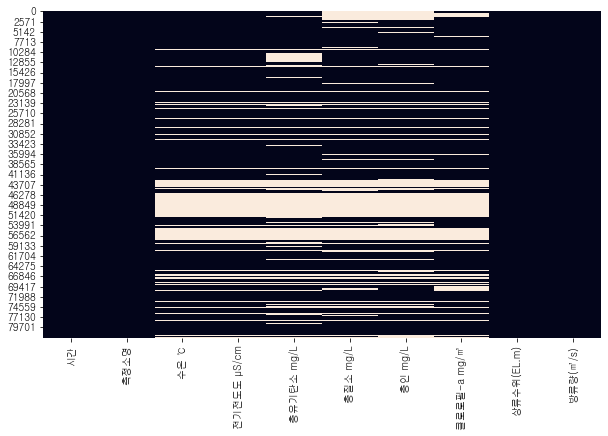

In [41]:
sns.heatmap(scb_data.isnull(), cbar=False)
plt.show()

수치형 특성 결측치들 사이의 피어슨 상관계수 확인 - 어떤 특성들이 함께 결측되었나를 확인함

In [42]:
scb_data_numeric = scb_data.iloc[:, 2:]
scb_data_numeric.isnull().corr(method='pearson')

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
수온 ℃,1.000000,0.997627,0.784735,0.771253,0.753176,0.893317,-0.005975,-0.005975
전기전도도 μS/cm,0.997627,1.000000,0.784629,0.770361,0.752133,0.891512,-0.005996,-0.005996
총유기탄소 mg/L,0.784735,0.784629,1.000000,0.698539,0.677277,0.726571,-0.005223,-0.005223
총질소 mg/L,0.771253,0.770361,0.698539,1.000000,0.884298,0.771919,-0.007758,-0.007758
총인 mg/L,0.753176,0.752133,0.677277,0.884298,1.000000,0.747514,-0.008128,-0.008128
클로로필-a mg/㎥,0.893317,0.891512,0.726571,0.771919,0.747514,1.000000,-0.006649,-0.006649
상류수위(EL.m),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000
방류량(㎥/s),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000


## 클로로필 정규화

회귀 모델을 적용하기 전에 클로로필 값이 정규 분포인지 확인. 왼쪽으로 치우친 형태임.

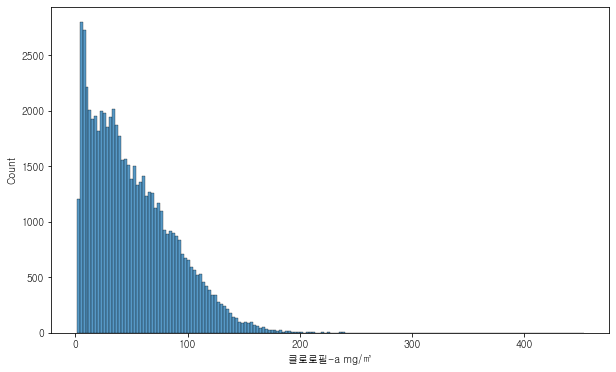

In [43]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포를 가짐. 

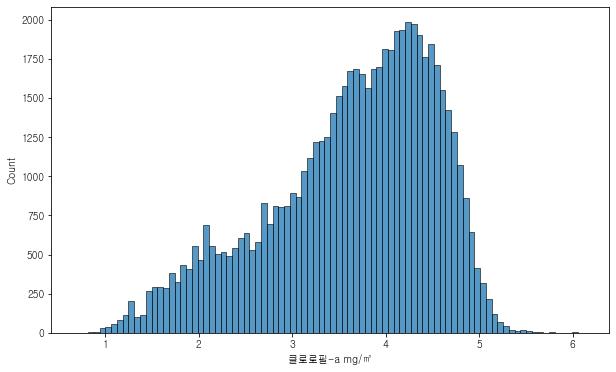

In [44]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환 뒤 `scb_data`에 추가

In [45]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

In [46]:
scb_data.head(3)

,시간,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
0,2013-01-01 00,용봉,3.9,374.0,2.5,NaN,NaN,7.2,7.5,19.748333,2.104134
1,2013-01-01 01,용봉,3.9,375.0,2.5,NaN,NaN,6.9,7.5,19.706667,2.066863
2,2013-01-01 02,용봉,4.0,374.0,2.5,NaN,NaN,6.8,7.5,19.723333,2.054124


In [47]:
scb_df = scb_data.copy()

## 결측치 보간법

In [48]:
from datetime import datetime

시간 특성을 date time 자료형으로 변환

In [49]:
scb_df['시간'] = scb_df['시간'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))

결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.      
예) 결측치가 36개인 구간이 있다면 처음~12개와 25~36개만 결측치 대체.  

In [50]:
scb_df = scb_df.copy().set_index('시간').interpolate(method='time', limit = 12, limit_direction='both')

결측치 제거

In [51]:
scb_df.dropna(inplace=True)

In [52]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59058 entries, 2013-03-29 04:00:00 to 2022-05-23 23:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정소명         59058 non-null  object 
 1   수온 ℃         59058 non-null  float64
 2   전기전도도 μS/cm  59058 non-null  float64
 3   총유기탄소 mg/L   59058 non-null  float64
 4   총질소 mg/L     59058 non-null  float64
 5   총인 mg/L      59058 non-null  float64
 6   클로로필-a mg/㎥  59058 non-null  float64
 7   상류수위(EL.m)   59058 non-null  float64
 8   방류량(㎥/s)     59058 non-null  float64
 9   log_Chl-a    59058 non-null  float64
dtypes: float64(9), object(1)
memory usage: 5.0+ MB


## 훈련 특성과 타깃  

log_Chl-a 은 타깃. 측정소명과 클로로필을 제외한 특성을 이용.

In [53]:
remove_feature = ['측정소명', '클로로필-a mg/㎥', 'log_Chl-a']

In [54]:
col = list(scb_df.columns)

for i in remove_feature:
    col.remove(i)

In [55]:
print(col)

['수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)']


## 모델 훈련 - RandomForest

In [56]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}

In [136]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [137]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [138]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [139]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
13,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.882534,1
12,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.881956,2
15,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.865974,3
14,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.865447,4
17,"{'max_depth': 15, 'min_samples_leaf': 16, 'n_e...",0.851648,5


In [140]:
rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 500}

In [141]:
estimator = rf_grid.best_estimator_

최신 모델 저장

In [142]:
joblib.dump(estimator, "승촌보_rf_전체.pkl")


['승촌보_rf_전체.pkl']

저장된 모델 다시 불러오기

In [57]:
estimator = joblib.load("승촌보_rf_전체.pkl")

In [58]:
estimator.oob_score_

0.902518429674803

In [59]:
pred = estimator.predict(X_test)

In [60]:
for score, name in zip(estimator.feature_importances_, col):
    print(round(score, 2), name)

0.22 수온 ℃
0.19 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.07 총질소 mg/L
0.06 총인 mg/L
0.15 상류수위(EL.m)
0.25 방류량(㎥/s)


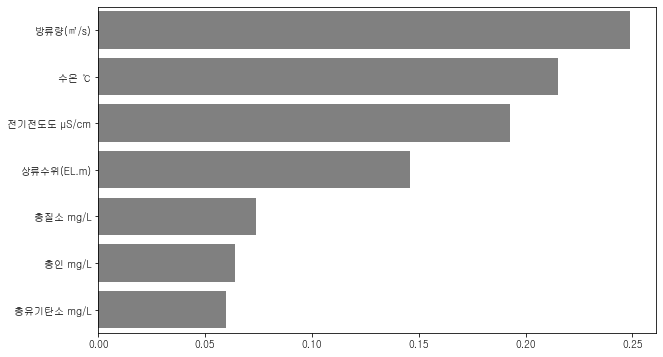

In [61]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [62]:
feature_series[:10]

방류량(㎥/s)       0.248706
수온 ℃           0.215017
전기전도도 μS/cm    0.192643
상류수위(EL.m)     0.145838
총질소 mg/L       0.073749
총인 mg/L        0.064111
총유기탄소 mg/L     0.059936
dtype: float64

In [64]:
print('score :', estimator.score(X_test, y_test))


score : 0.9038319082324255


## 모델 훈련 - GradientBoosting

In [65]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [109]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [111]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.727 total time=   5.5s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.736 total time=   6.1s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.729 total time=   6.6s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.901 total time=  12.6s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.904 total time=  10.9s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.902 total time=  10.3s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.926 total time=  14.8s
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.927 total time=  14.8s
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.926 total time=  15.6s
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.762 total time=   5.3s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.774 total time=   5.3s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [112]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [113]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.926356,1
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.926246,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.925979,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.923528,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.916023,5


In [114]:
gb_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 15}

In [115]:
estimator = gb_grid.best_estimator_

**최신 모델 저장**

In [116]:
import joblib

In [117]:
joblib.dump(estimator, "승촌보_gb_전체.pkl")

['승촌보_gb_전체.pkl']

저장된 모델을 다시 불러오기

In [66]:
estimator = joblib.load("승촌보_gb_전체.pkl")

In [67]:
pred = estimator.predict(X_test)

In [68]:
for score, name in zip(estimator.feature_importances_, col):
    print(round(score, 2), name)

0.21 수온 ℃
0.2 전기전도도 μS/cm
0.07 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.14 상류수위(EL.m)
0.23 방류량(㎥/s)


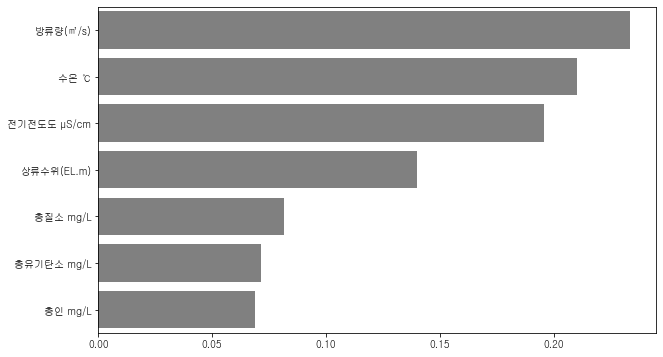

In [69]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [70]:
feature_series[:10]

방류량(㎥/s)       0.233123
수온 ℃           0.210120
전기전도도 μS/cm    0.195613
상류수위(EL.m)     0.139688
총질소 mg/L       0.081668
총유기탄소 mg/L     0.071223
총인 mg/L        0.068566
dtype: float64

In [71]:
print('score :', estimator.score(X_test, y_test))


score : 0.9461462695967687
